In [1]:
import sys,os,copy,glob,time
import numpy as np
sys.path.append(os.path.abspath('../../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
from smodels.tools import statistics
from smodels.tools.simplifiedLikelihoods import UpperLimitComputer, Data, LikelihoodComputer
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special

from smodels.experiment.databaseObj import Database
from tqdm.notebook import tqdm
from multiprocessing import Pool
import warnings
import shutil

runtime._cap_likelihoods = True
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))


In [2]:
def getSRs():
    from smodels.experiment.databaseObj import Database
    db = Database ( "official" )
    ers = db.getExpResults( dataTypes=[ "efficiencyMap" ] )
    stats_ = []
    for er in ers:
        for ds in er.datasets:
            D = { "obsN": ds.dataInfo.observedN, "expectedBG": ds.dataInfo.expectedBG,
                  "bgError": ds.dataInfo.bgError, "upperLimit": ds.dataInfo.upperLimit,
                  "expectedUpperLimit": ds.dataInfo.expectedUpperLimit }
            stats_.append ( D )
    return stats_

In [3]:
stats_ = getSRs()

In [4]:
def getNorm(func, args, b, getMulim=False):
    err = 1.
    ctr = 0
    b = 2*b
    norm = integrate.quad(func, 0 , b, args, epsabs=0.,epsrel=1e-3)[0]
    while err > 0.01:
        ctr+=1
        if ctr > 50.:
            raise Exception("Could not compute norm within required precision")
        norm_old = norm
        b = b*1.2
        norm = integrate.quad(func, 0, b, args, epsabs=0., epsrel=1e-3)[0]
        if norm == 0.:
            continue
        err = abs(norm_old-norm)/norm
    if getMulim:
        return norm, b
    return norm

In [5]:
# ### Compute observed and expected upper limits
def run ( nobs, nExp, nExpErr, nsig, plotname=False ):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_gauss = getNorm(smllhd.marginalizedLLHD1D, args=(False), b=max(ULobs,ULexp))
    norm_loggauss = getNorm(smllhd.marginalizedLLHD1D, args=(False, "lognormal"), b=max(ULobs,ULexp))
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    #norm_gauss = integrate.quad(smllhd.marginalizedLLHD1D, 0, mulim, args=(False))[0]
    #norm_loggauss = integrate.quad(smllhd.marginalizedLLHD1D, 0, mulim, args=(False, "lognormal"))[0]
    #norm_profiled = integrate.quad(smllhd.profileLikelihood, 0, mulim, args=(False))[0]
    
    llhds_app_norm0 = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_0")] for mu in muvals])
    llhds_app_norm_neg = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="norm_neg")] for mu in muvals])
    llhds_app_exp = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct="exp")] for mu in muvals])
    llhds_full_norm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False)/norm_gauss] for mu in muvals])
    llhds_full_lognorm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False, bg_error="lognormal")/norm_loggauss] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(15,8))
    plt.plot(llhds_full_norm[:,0],llhds_full_norm[:,1],label='Smodels Full',linewidth=3, color="black")
    plt.plot(llhds_full_lognorm[:,0],llhds_full_lognorm[:,1],label='Smodels Full log',linewidth=3, color="blue")
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Smodels Full profiled',linewidth=3, color="brown")
    plt.plot(llhds_app_norm0[:,0],llhds_app_norm0[:,1],label='Gauss loc=0', linestyle='--', linewidth=3)
    plt.plot(llhds_app_exp[:,0],llhds_app_exp[:,1],label='Exp', linestyle='--', linewidth=3)
    plt.plot(llhds_app_norm_neg[:,0],llhds_app_norm_neg[:,1],label='Gauss loc<0', linestyle='--', linewidth=3)
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("./plots/"+str(plotname))
    plt.close()
    


Starting run with nobs 9 nExp 11.8
Nobs = 9.00, Nbg = 11.80 +- 3.10, Nsig < 7.23, Nsig (expected) < 10.14


WARNING in font_manager._findfont_cached() in 1355: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
WARNING in font_manager._findfont_cached() in 1355: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
WARNING in font_manager._findfont_cached() in 1355: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


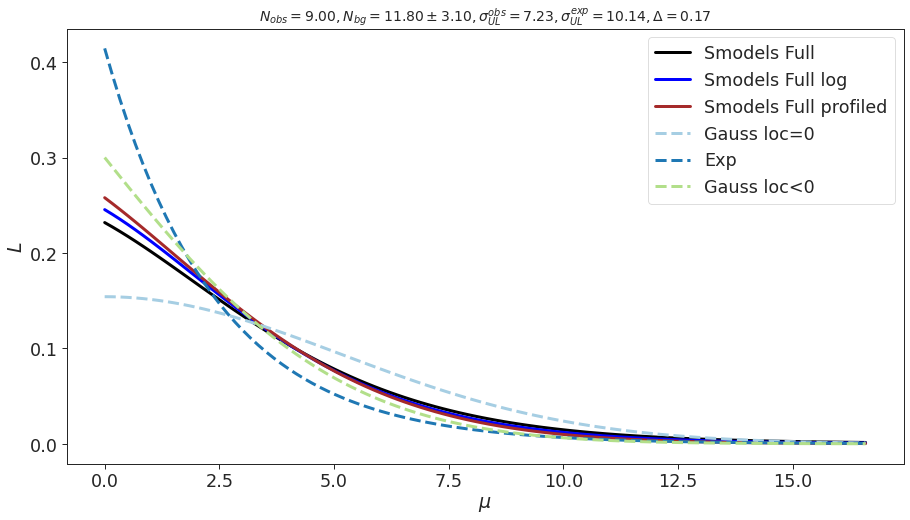

In [6]:
j = 10
t = run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

Starting run with nobs 11 nExp 4.2
Nobs = 11.00, Nbg = 4.20 +- 3.40, Nsig < 15.84, Nsig (expected) < 7.98


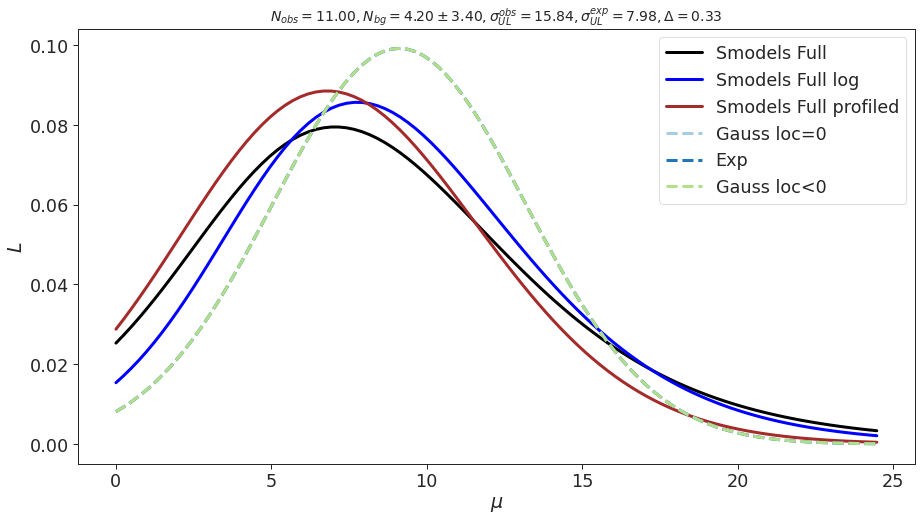

In [7]:
j = 44
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [8]:
def num_moments(funct, mulim=np.inf):
    integrand_ev = lambda mu: mu*funct(mu)
    ev = integrate.quad(integrand_ev, 0., mulim, epsabs=0.,epsrel=1e-3)[0]
    
    integrand_var = lambda mu: (mu**2)*funct(mu)
    ev_x2 = integrate.quad(integrand_var, 0, mulim,epsabs=0.,epsrel=1e-3)[0]
    var = ev_x2 - ev**2
    
    integrand_skew = lambda mu: (mu**3)*funct(mu)
    ev_x3 = integrate.quad(integrand_skew, 0, mulim, epsabs=0.,epsrel=1e-3)[0]
    skew = ( ev_x3 - 3*ev*var - ev**3 ) / (var**(3/2))
    
    negllhd = lambda mu: -funct(mu)
    res = optimize.minimize(fun=negllhd, x0=ev, method="TNC", bounds=[(0.,np.inf)])
    if res["x"]<1e-5:
        mod = 0
    else:    
        mod = float(res["x"])
    
    return ({"ev":ev, "var":var, "skew":skew, "mode":mod})

In [9]:
# ### Compute observed and expected upper limits
def compare_methods ( nobs, nExp, nExpErr, nsig ):
    """ TODO:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )

    smllhd = LikelihoodComputer(data)
    
    res = {}
    
    modes_full = {"normal", "lognormal"}
    for mode in modes_full:
        norm, mulim = getNorm(smllhd.marginalizedLLHD1D, args=(False, mode), b=max(ULobs,ULexp), getMulim=True)
        llhd_full = lambda mu: smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        #def llhd_full(mu): smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        #    return smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        res[mode] = num_moments(llhd_full, mulim)
    
    norm_profiled, mulim_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp), getMulim=True)
    llhd_profiled = lambda mu: smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    #def llhd_profiled(mu):
    #    return smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    res["profiled"] = num_moments(llhd_profiled, mulim_profiled)
    
    modes_app = ["norm_0", "norm_neg", "exp"]
    for mode in modes_app:
        res[mode] = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    
    #for mode in modes:
    #    def llhd_from_limits(mu):
    #        return statistics.likelihoodFromLimits(ULobs, ULexp, mu, underfluct=mode)
    #    result1 = num_moments(llhd_from_limits, np.inf)
    #    result2 = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    #    print(mode, result1, "\n", result2)

    
    return res   

Starting run with nobs 3 nExp 3.1
Nobs = 3.00, Nbg = 3.10 +- 1.30, Nsig < 5.19, Nsig (expected) < 5.19


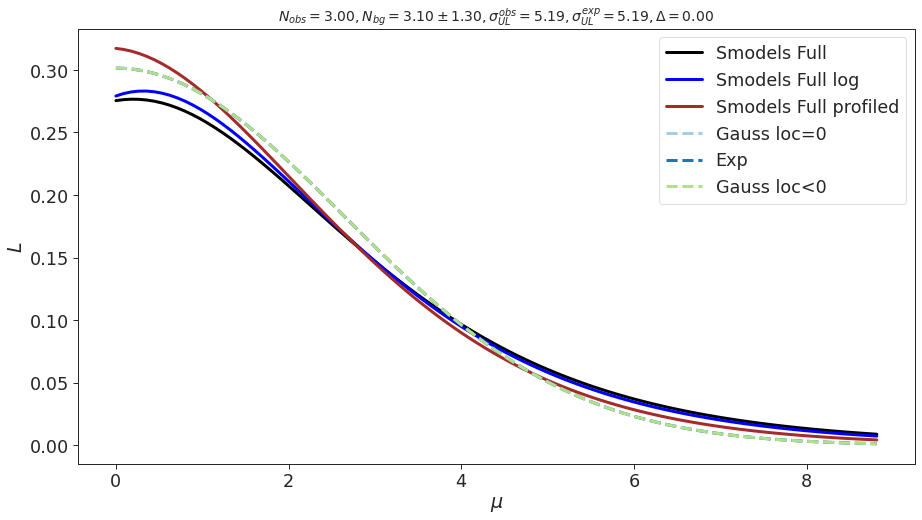

In [10]:
j = 31
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [11]:
test = compare_methods (int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [12]:
#test

In [13]:
llhds_meta =[]
for i in tqdm(range(len(stats_))):
    try:
        #print(i)
        llhds_meta.append(compare_methods (int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1))
    except:
        print("Error: ",i)

  0%|          | 0/271 [00:00<?, ?it/s]

WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.llhdFromLimits_moments() in 242: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.


In [14]:
llhds_meta[178]

{'lognormal': {'ev': 695.9394182003374,
  'var': 339134.18160071864,
  'skew': 1.3971379735794944,
  'mode': 0},
 'normal': {'ev': 716.9616353341111,
  'var': 375147.5154292569,
  'skew': 1.4807625246323315,
  'mode': 0},
 'profiled': {'ev': 651.9637285931592,
  'var': 271467.45859668497,
  'skew': 1.1378043750444935,
  'mode': 0},
 'norm_0': {'ev': 779.7634955705255,
  'var': 347061.9236081348,
  'skew': 0.9952717464311566,
  'mode': 0},
 'norm_neg': {'ev': 598.287730734385,
  'var': 239745.3268633217,
  'skew': 1.2039541030172523,
  'mode': 0.0},
 'exp': {'ev': 521.8063091208546,
  'var': 272281.8242383289,
  'skew': 2,
  'mode': 0.0}}

In [15]:
def reldiff(ex, app):
    if(ex < 0 or app < 0): return(warnings.warn("Negative Value encountered"))
    if(ex+app == 0): return(0)
    return(2*(ex-app) / (app+ex))

In [16]:
modes_full = ["normal", "lognormal", "profiled"]
modes_app = ["norm_0", "norm_neg", "exp"]
moments = ["ev", "var", "skew", "mode"]
reldiffs = []

for i in range(len(llhds_meta)):
    tempdict = {}
    for mode_f in modes_full:
        for mode_a in modes_app:
            for moment in moments:
                try:
                    ex = llhds_meta[i][mode_f][moment]
                    app = llhds_meta[i][mode_a][moment]
                    tempdict[mode_f+"_vs_"+mode_a+"_"+moment] = reldiff(ex, app)
                except:
                    print(i, mode_f, mode_a, moment)
    reldiffs.append(tempdict)
        

In [17]:
print("Means of relative Differences: \n")
for moment in moments:
    for mode_f in modes_full:
        for mode_a in modes_app:
            mean = np.mean([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(reldiffs))])
            print(mode_f+" vs "+mode_a+" "+moment+": \t", mean)
        print("\n")

Means of relative Differences: 

normal vs norm_0 ev: 	 -0.030238643813016462
normal vs norm_neg ev: 	 0.11865341229945198
normal vs exp ev: 	 0.1649721665118801


lognormal vs norm_0 ev: 	 -0.07584431074880896
lognormal vs norm_neg ev: 	 0.07237006428564496
lognormal vs exp ev: 	 0.11903843173042632


profiled vs norm_0 ev: 	 -0.14740216201568598
profiled vs norm_neg ev: 	 0.0004735115018389065
profiled vs exp ev: 	 0.04726641205217066


normal vs norm_0 var: 	 0.26929844276391823
normal vs norm_neg var: 	 0.48221148103844763
normal vs exp var: 	 0.43890420909553096


lognormal vs norm_0 var: 	 0.11847328839529779
lognormal vs norm_neg var: 	 0.33182763976790053
lognormal vs exp var: 	 0.2871841066148335


profiled vs norm_0 var: 	 -0.059694852592294304
profiled vs norm_neg var: 	 0.15310167992000698
profiled vs exp var: 	 0.10785478002203279


normal vs norm_0 skew: 	 0.5668089327331748
normal vs norm_neg skew: 	 0.4736413572673671
normal vs exp skew: 	 0.29695969950223866


lognorma

In [18]:
def makehists():
    for mode_f in modes_full:
        for mode_a in modes_app:
            for moment in moments:
                fig = plt.figure(figsize=(10,7))
                plt.hist([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
                plt.title(mode_f+" vs "+mode_a+": "+moment)
                plt.savefig("./hists/"+mode_f+" vs "+mode_a+": "+moment)
                plt.close()

In [35]:
list_lower = [stats_[x]["obsN"] < stats_[x]["expectedBG"] for x in range(len(stats_))]
list_greater = [stats_[x]["obsN"] >= stats_[x]["expectedBG"] for x in range(len(stats_))]
lower = np.where(list_lower)[0]
greater = np.where(list_greater)[0]

In [36]:
len(lower)+len(greater)

271

In [37]:
def find_range(mode_f):
    range_={}
    for moment in moments:
        ma = -1e2
        mi = 1e2
        for mode_a in modes_app:
            ma_temp = max([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
            mi_temp = min([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
            if ma < ma_temp: ma = ma_temp
            if mi > mi_temp: mi = mi_temp
        range_[moment]=(mi,ma)
    return(range_)

In [42]:
def makehists():
    bins_=15
    
    #single Hists
    #for mode_f in modes_full:
    #    for mode_a in modes_app:
    #        for moment in moments:
    #            fig = plt.figure(figsize=(10,7))
    #            plt.hist([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))])
    #            plt.title(mode_f+" vs "+mode_a+": "+moment)
    #            plt.savefig("./hists/"+mode_f+" vs "+mode_a+": "+moment)
    #            plt.close()
    
    #grouped Hists
    for mode_f in modes_full:
        fig, ax = plt.subplots(4,3, figsize=(20,10), constrained_layout=True)
        fig.suptitle(mode_f)
        j = 0
        for mode_a in modes_app:
            i = 0
            for moment in moments:
                if i == 0:
                    ax[i,j].set_title("vs "+mode_a+"\n"+moment)
                else:
                    ax[i,j].set_title(moment)
                ax[i,j].hist([reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta))], bins=bins_)
                i += 1
            j += 1
        plt.savefig("./hists/"+mode_f)
        plt.close()
        plt.show()
        
    #grouped stacked Hists    
    for mode_f in modes_full:
        #fig, ax = plt.subplots(4,3, figsize=(20,10), constrained_layout=True, sharey=True)
        fig, ax = plt.subplots(4,3, figsize=(22,11), constrained_layout=True)
        fig.suptitle(mode_f)
        j = 0
        ranges = find_range(mode_f)
        for mode_a in modes_app:
            i = 0
            for moment in moments:
                if i == 0:
                    ax[i,j].set_title("vs "+mode_a+"\n"+moment)
                else:
                    ax[i,j].set_title(moment)
                obsNlower = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in lower]  
                obsNgreater = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in greater]
                ax[i,j].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["ObsN>=ExpBG","ObsN<ExpBG"])
                ax[i,j].legend()
                i += 1
            j += 1
       
        plt.savefig("./hists/"+mode_f+"_stacked")
        plt.close()
        plt.show()

In [43]:
if not os.path.exists("hists"):
    os.mkdir("hists")
    makehists()
else:
    new_plot = input('Would you like to redo the hists? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("hists")
        os.mkdir("hists")
        makehists()
    else:
        print("Aborting")

Would you like to redo the hists? (y/n)
y


In [65]:
if not os.path.exists("plots"):
    os.mkdir("plots")
    for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
else:
    new_plot = input('Would you like to redo the Plots? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("plots")
        os.mkdir("plots")
        for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
    else:
        print("Aborting")

Would you like to redo the Plots? (y/n)
y


  0%|          | 0/271 [00:00<?, ?it/s]

Starting run with nobs 12 nExp 5.5
Nobs = 12.00, Nbg = 5.50 +- 0.72, Nsig < 13.32, Nsig (expected) < 6.79
Starting run with nobs 1 nExp 1.25
Nobs = 1.00, Nbg = 1.25 +- 0.26, Nsig < 3.21, Nsig (expected) < 3.21
Starting run with nobs 1 nExp 1.03
Nobs = 1.00, Nbg = 1.03 +- 0.18, Nsig < 3.39, Nsig (expected) < 3.39
Starting run with nobs 263 nExp 283
Nobs = 263.00, Nbg = 283.00 +- 24.00, Nsig < 42.10, Nsig (expected) < 57.87
Starting run with nobs 191 nExp 191
Nobs = 191.00, Nbg = 191.00 +- 21.00, Nsig < 49.67, Nsig (expected) < 49.67
Starting run with nobs 26 nExp 23
Nobs = 26.00, Nbg = 23.00 +- 4.00, Nsig < 15.86, Nsig (expected) < 13.08
Starting run with nobs 7 nExp 4.1
Nobs = 7.00, Nbg = 4.10 +- 1.10, Nsig < 8.98, Nsig (expected) < 5.53
Starting run with nobs 7 nExp 13.2
Nobs = 7.00, Nbg = 13.20 +- 2.20, Nsig < 4.91, Nsig (expected) < 9.12
Starting run with nobs 4 nExp 6.9
Nobs = 4.00, Nbg = 6.90 +- 1.50, Nsig < 4.55, Nsig (expected) < 7.17
Starting run with nobs 3 nExp 4.2
Nobs = 3.0

Starting run with nobs 16 nExp 8.8
Nobs = 16.00, Nbg = 8.80 +- 2.80, Nsig < 16.49, Nsig (expected) < 9.06
Starting run with nobs 11 nExp 11.3
Nobs = 11.00, Nbg = 11.30 +- 3.10, Nsig < 9.41, Nsig (expected) < 9.41
Starting run with nobs 7 nExp 7.3
Nobs = 7.00, Nbg = 7.30 +- 1.50, Nsig < 6.78, Nsig (expected) < 6.78
Starting run with nobs 0 nExp 1.1
Nobs = 0.00, Nbg = 1.10 +- 1.10, Nsig < 3.15, Nsig (expected) < 3.77
Starting run with nobs 64 nExp 45.7
Nobs = 64.00, Nbg = 45.70 +- 5.95, Nsig < 35.99, Nsig (expected) < 18.76
Starting run with nobs 981 nExp 965.9
Nobs = 981.00, Nbg = 965.90 +- 85.28, Nsig < 192.63, Nsig (expected) < 178.16
Starting run with nobs 23 nExp 11.8
Nobs = 23.00, Nbg = 11.80 +- 2.41, Nsig < 20.98, Nsig (expected) < 9.45
Starting run with nobs 249 nExp 285.5
Nobs = 249.00, Nbg = 285.50 +- 27.08, Nsig < 37.16, Nsig (expected) < 63.44
Starting run with nobs 48 nExp 38.8
Nobs = 48.00, Nbg = 38.80 +- 6.54, Nsig < 27.03, Nsig (expected) < 18.59
Starting run with nobs 49

Starting run with nobs 2 nExp 1.0
Nobs = 2.00, Nbg = 1.00 +- 0.50, Nsig < 4.77, Nsig (expected) < 3.50
Starting run with nobs 3 nExp 3.2
Nobs = 3.00, Nbg = 3.20 +- 0.70, Nsig < 4.74, Nsig (expected) < 4.74
Starting run with nobs 21 nExp 23.3
Nobs = 21.00, Nbg = 23.30 +- 3.70, Nsig < 10.70, Nsig (expected) < 12.46
Starting run with nobs 33 nExp 38.2
Nobs = 33.00, Nbg = 38.20 +- 5.10, Nsig < 12.41, Nsig (expected) < 16.31
Starting run with nobs 5 nExp 3.3
Nobs = 5.00, Nbg = 3.30 +- 0.70, Nsig < 7.14, Nsig (expected) < 4.65
Starting run with nobs 217 nExp 236
Nobs = 217.00, Nbg = 236.00 +- 29.00, Nsig < 48.85, Nsig (expected) < 64.62
Starting run with nobs 12 nExp 13
Nobs = 12.00, Nbg = 13.00 +- 2.20, Nsig < 8.53, Nsig (expected) < 9.32
Starting run with nobs 11 nExp 15.8
Nobs = 11.00, Nbg = 15.80 +- 1.90, Nsig < 6.33, Nsig (expected) < 10.01
Starting run with nobs 4 nExp 4.1
Nobs = 4.00, Nbg = 4.10 +- 0.80, Nsig < 5.38, Nsig (expected) < 5.38
Starting run with nobs 5 nExp 4.1
Nobs = 5.00

Starting run with nobs 32 nExp 22.8
Nobs = 32.00, Nbg = 22.80 +- 5.20, Nsig < 23.48, Nsig (expected) < 14.73
Starting run with nobs 98 nExp 109
Nobs = 98.00, Nbg = 109.00 +- 18.00, Nsig < 31.88, Nsig (expected) < 41.12
Starting run with nobs 38 nExp 42.8
Nobs = 38.00, Nbg = 42.80 +- 9.50, Nsig < 18.64, Nsig (expected) < 23.27
Starting run with nobs 23 nExp 17.6
Nobs = 23.00, Nbg = 17.60 +- 4.10, Nsig < 17.57, Nsig (expected) < 12.72
Starting run with nobs 94 nExp 86
Nobs = 94.00, Nbg = 86.00 +- 17.00, Nsig < 46.00, Nsig (expected) < 38.26
Starting run with nobs 39 nExp 29.7
Nobs = 39.00, Nbg = 29.70 +- 5.80, Nsig < 25.20, Nsig (expected) < 16.61
Starting run with nobs 6159 nExp 6088
Nobs = 6159.00, Nbg = 6088.00 +- 665.00, Nsig < 1383.21, Nsig (expected) < 1312.36
Starting run with nobs 2305 nExp 2278
Nobs = 2305.00, Nbg = 2278.00 +- 266.00, Nsig < 556.51, Nsig (expected) < 529.73
Starting run with nobs 454 nExp 418
Nobs = 454.00, Nbg = 418.00 +- 66.00, Nsig < 171.06, Nsig (expected) <

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.


Starting run with nobs 2 nExp 0.5
Nobs = 2.00, Nbg = 0.50 +- 2.60, Nsig < 7.76, Nsig (expected) < 2.92


WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oUL(7.76) and eUL(2.92) is too large (dr=0.91>0.87). capping to 7.39.
WARNING in statistics.likelihoodFromLimits() in 83: asking for likelihood from limit but difference between oU

Starting run with nobs 18 nExp 21.1
Nobs = 18.00, Nbg = 21.10 +- 8.10, Nsig < 15.74, Nsig (expected) < 18.49
Starting run with nobs 3 nExp 7.9
Nobs = 3.00, Nbg = 7.90 +- 3.60, Nsig < 5.02, Nsig (expected) < 9.68
Starting run with nobs 266 nExp 290
Nobs = 266.00, Nbg = 290.00 +- 65.00, Nsig < 109.88, Nsig (expected) < 131.78
Starting run with nobs 62 nExp 52
Nobs = 62.00, Nbg = 52.00 +- 12.00, Nsig < 37.52, Nsig (expected) < 27.81
Starting run with nobs 9 nExp 0.8
Nobs = 9.00, Nbg = 0.80 +- 3.30, Nsig < 16.62, Nsig (expected) < 7.14
Starting run with nobs 111 nExp 124
Nobs = 111.00, Nbg = 124.00 +- 29.00, Nsig < 49.58, Nsig (expected) < 61.06
Starting run with nobs 35 nExp 28.6
Nobs = 35.00, Nbg = 28.60 +- 6.90, Nsig < 23.79, Nsig (expected) < 18.10
Starting run with nobs 4 nExp 6.0
Nobs = 4.00, Nbg = 6.00 +- 2.80, Nsig < 6.01, Nsig (expected) < 7.99
Starting run with nobs 8 nExp 5.6
Nobs = 8.00, Nbg = 5.60 +- 2.30, Nsig < 10.05, Nsig (expected) < 7.83
Starting run with nobs 5 nExp 7.1


In [48]:
llhds_meta[0]

{'lognormal': {'ev': 8.182459072789195,
  'var': 18.746639628890037,
  'skew': 0.8930306102099304,
  'mode': 6.439413990182695},
 'normal': {'ev': 8.290415122408467,
  'var': 20.512641273671576,
  'skew': 1.03859271746429,
  'mode': 6.394750707230111},
 'profiled': {'ev': 7.513827431046522,
  'var': 13.174211635605886,
  'skew': 0.5814691453151103,
  'mode': 6.500172569560479},
 'norm_0': {'ev': 7.7253872553756535,
  'var': 11.018005007465643,
  'skew': 0.16786018284929277,
  'mode': 7.599234169801763},
 'norm_neg': {'ev': 7.7253872553756535,
  'var': 11.018005007465643,
  'skew': 0.16786018284929277,
  'mode': 7.599234169801763},
 'exp': {'ev': 7.7253872553756535,
  'var': 11.018005007465643,
  'skew': 0.16786018284929277,
  'mode': 7.599234169801763}}

In [63]:
print("i \t mode_f \t mode_a \t relldifs(mode) \t (obsN,ExpBG) \n")
for mode_f in modes_full:
    for mode_a in modes_app:
        for i in range(len(reldiffs)):
                if reldiffs[i][mode_f+"_vs_"+mode_a+"_"+"mode"] > 1.9:
                    #print (i, mode_f, reldiffs[i][mode_f+"_vs_"+mode_a+"_"+"mode"], llhds_meta[i][mode_f]["mode"], llhds_meta[i][mode_a]["mode"],\
                    #      (stats_[i]["obsN"], stats_[i]["expectedBG"]))
                    print (i, "\t", mode_f,"\t", mode_a, "\t",reldiffs[i][mode_f+"_vs_"+mode_a+"_"+"mode"],\
                          "\t",(stats_[i]["obsN"],stats_[i]["expectedBG"]))


i 	 mode_f 	 mode_a 	 relldifs(mode) 	 (obsN,ExpBG) 

4 	 normal 	 norm_0 	 1.9917500392137675 	 (191, 191)
24 	 normal 	 norm_0 	 1.9968545094367824 	 (2.0, 2.0)
31 	 normal 	 norm_0 	 1.9971497045059605 	 (3.0, 3.1)
37 	 normal 	 norm_0 	 1.9914902407693018 	 (115, 115)
47 	 normal 	 norm_0 	 1.998805290635887 	 (2, 1.6)
69 	 normal 	 norm_0 	 1.998575366341231 	 (4, 3.7)
78 	 normal 	 norm_0 	 1.993351220329054 	 (11, 11.3)
88 	 normal 	 norm_0 	 1.9940745034691638 	 (39, 39.0)
96 	 normal 	 norm_0 	 1.9983772062777452 	 (3, 2.81)
123 	 normal 	 norm_0 	 1.9917307846032954 	 (5, 5.2)
127 	 normal 	 norm_0 	 1.9972803010307623 	 (17, 17)
161 	 normal 	 norm_0 	 1.9849405394443007 	 (4, 4.1)
167 	 normal 	 norm_0 	 1.999130741533841 	 (2, 1.6)
170 	 normal 	 norm_0 	 1.9949008704760904 	 (21, 21.2)
171 	 normal 	 norm_0 	 1.9933195191194546 	 (3, 3.2)
188 	 normal 	 norm_0 	 1.983532094345021 	 (254, 254.3)
199 	 normal 	 norm_0 	 1.9982453073708086 	 (6, 5.9)
204 	 normal 	 norm_0 	 

172 	 profiled 	 norm_0 	 1.9956699945826106 	 (1, 0.9)
199 	 profiled 	 norm_0 	 1.9920485355037032 	 (6, 5.9)
264 	 profiled 	 norm_0 	 1.990124383781961 	 (1, 0.96)
268 	 profiled 	 norm_0 	 1.997824901876985 	 (1, 0.81)
47 	 profiled 	 norm_neg 	 1.9987154922640509 	 (2, 1.6)
69 	 profiled 	 norm_neg 	 1.9978363603060048 	 (4, 3.7)
96 	 profiled 	 norm_neg 	 1.9969729874393858 	 (3, 2.81)
105 	 profiled 	 norm_neg 	 1.9987614720103775 	 (1.0, 0.6)
167 	 profiled 	 norm_neg 	 1.998648444387008 	 (2, 1.6)
172 	 profiled 	 norm_neg 	 1.9956699945826106 	 (1, 0.9)
199 	 profiled 	 norm_neg 	 1.9920485355037032 	 (6, 5.9)
264 	 profiled 	 norm_neg 	 1.990124383781961 	 (1, 0.96)
268 	 profiled 	 norm_neg 	 1.997824901876985 	 (1, 0.81)
47 	 profiled 	 exp 	 1.9987154922640509 	 (2, 1.6)
69 	 profiled 	 exp 	 1.9978363603060048 	 (4, 3.7)
96 	 profiled 	 exp 	 1.9969729874393858 	 (3, 2.81)
105 	 profiled 	 exp 	 1.9987614720103775 	 (1.0, 0.6)
167 	 profiled 	 exp 	 1.998648444387008 	 